In [1]:
# Librerías generales
import pandas as pd
import numpy as np
import os

# Gráficos y visualización
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import textwrap
from IPython.display import display, HTML

# Gestión de advertencias
import warnings
warnings.filterwarnings('ignore')

# Estadísticas y pruebas
from scipy import stats
from scipy.stats import ttest_ind, pearsonr, spearmanr, pointbiserialr, chi2_contingency, mannwhitneyu

# Modelos y evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Análisis de multicolinealidad
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2. Integración y selección

La siguiente es la información del dataset:

## Variables numéricas:

- __edad__: edad en años
- __trtbps__: presión arterial en reposo (en mm Hg al ingreso al hospital)
- __chol__: colestoral sérico en mg/dl
- __thalachh__: frecuencia cardíaca máxima alcanzada
- __oldpeak__: depresión del ST inducida por el ejercicio en relación con el reposo

## Variables categóricas:

- __sex__: género (1 = masculino; 0 = femenino)
- __cp__: tipo de dolor torácico (1 = angina típica; 2 = angina atípica; 3 = dolor no anginoso; 0 = asintomático). 
  - ___Nota: hemos supuesto que el valor 0 es asintomático, ya que no hay observaciones con valor 4 en la muestra___ Esta suposición la hemos podido confirmar en [uno de los foros de debate de Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843).
- __fbs__: azúcar en sangre en ayunas > 120 mg/dl (1 = verdadero; 0 = falso)
- __restecg__: resultados electrocardiográficos en reposo (1 = normal; 2 = con anomalías en la onda ST-T; 0 = hipertrofia)
- __exng__: angina inducida por el ejercicio (1 = sí; 0 = no)
- __slp__: la pendiente del segmento ST del ejercicio máximo (2 = pendiente ascendente; 1 = plano; 0 = pendiente descendente)
- __caa__: número de vasos principales (0-3) coloreados por fluoroscopia
- __thall__: prueba de esfuerzo con talio (2 = normal; 1 = defecto fijo; 3 = defecto reversible; 0 = null)

## Variable Target

- __output__: diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfico)
  - 0: < 50% de estrechamiento del diámetro. menos posibilidades de enfermedades del corazón
  - 1: > 50% de estrechamiento del diámetro. más posibilidades de enfermedades del corazón


In [2]:
# Variables categóricas
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
# Variables numéricas
numerical_vars=['chol', 'thalachh', 'trtbps', 'age', 'oldpeak']
# Variables independientes
independent_vars = categorical_vars + numerical_vars
# Variable target
target_var = 'output'

## Carga dataset

In [3]:
# lectura dataset
df_original = pd.read_csv('../datasets/heart.csv')
# Obtener información sobre las variables del DataFrame
df_original.info()
df_original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Reducción de la dimensionalidad

Este conjunto de métodos tiene por objetivo reducir el número de atributos bajo consideración. Pueden dividirse en métodos paramétricos y no paramétricos.

Dado que el conjunto de datos es pequeño, con solo 303 registros, y la cantidad de variables independientes es limitada, no es necesario aplicar métodos de reducción de la dimensionalidad. Al conservar todas las variables en el análisis, mantenemos la interpretación completa de los resultados y evitamos la posibilidad de perder información relevante.

Aunque no sea estrictamente necesario debido al tamaño reducido del conjunto de datos y la cantidad limitada de variables independientes, con fines explicativos y para mostrar el procedimiento, procederemos a aplicar la reducción de la dimensionalidad por el método Análisis de componentes principales (ACP).

En este análisis, es importante no incluir la variable "output" debido a que ACP es una técnica de aprendizaje no supervisada. Esto significa que no tiene en cuenta la variable objetivo o las etiquetas de clase al calcular las componentes principales. Incluir la variable "output" en el ACP podría introducir un sesgo en los resultados, ya que esta variable no debería influir en la identificación de las nuevas componentes que son una combinación lineal de nuestras características originales.

In [4]:
# Separar la variable dependiente 'output' del dataset al que aplicaremos PCA
df_independiente = df_original[independent_vars]

# Crear una instancia de PCA
pca = PCA()

# Ajustar el modelo PCA a tus datos
pca.fit(df_independiente)

# Obtener la varianza explicada por cada componente
variance_ratio = pca.explained_variance_ratio_

# Calcular la varianza acumulada explicada
cumulative_variance_ratio = np.cumsum(variance_ratio)

# Establecer el umbral de varianza explicada deseado
threshold = 0.95

# Obtener el número de componentes que superan el umbral
n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

print("Número de componentes necesarios para alcanzar una varianza explicada del", threshold, ":", n_components)

# Reducir la dimensionalidad utilizando el número de componentes adecuado
pca = PCA(n_components=n_components)
df_reduced = pca.fit_transform(df_original)

# Crear un nuevo dataframe con las componentes principales
column_names = [f"Component_{i+1}" for i in range(n_components)]
df_reduced = pd.DataFrame(df_reduced, columns=column_names)

# Imprimir el dataframe reducido
df_combined = pd.concat([df_reduced, df_original[target_var]], axis=1)
print("Dataframe reducido:")
df_combined.info()
df_combined.head()

df_combined.to_csv('../datasets/heart_reducted_pca.csv', index=False)

Número de componentes necesarios para alcanzar una varianza explicada del 0.95 : 3
Dataframe reducido:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Component_1  303 non-null    float64
 1   Component_2  303 non-null    float64
 2   Component_3  303 non-null    float64
 3   output       303 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 9.6 KB


# 3. Limpieza de los datos


## 3.1 Valores ausentes

In [5]:
# Verificar si hay valores ausentes en los datos
print("Valores nulos:")
print(df_original.isnull().sum())

# Iterar sobre las columnas categóricas y mostrar los valores únicos
for variable in categorical_vars:
    valores_unicos = df_original[variable].unique()
    print("Valores únicos en la variable", variable, ":", valores_unicos)

Valores nulos:
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
Valores únicos en la variable sex : [1 0]
Valores únicos en la variable cp : [3 2 1 0]
Valores únicos en la variable fbs : [1 0]
Valores únicos en la variable restecg : [0 1 2]
Valores únicos en la variable exng : [0 1]
Valores únicos en la variable slp : [0 2 1]
Valores únicos en la variable caa : [0 2 1 3 4]
Valores únicos en la variable thall : [1 2 3 0]


En base a la información de la descripción del dataset, solo la variable ___thall___ tiene valores ausentes (0):

- 1 = fixed defect
- 2 = normal
- 3 = reversable defect
- 0 = null

Al ser solo 2 observaciones las que tienen valor ausente '0' en la variable thall, proponemos 2 posibles opciones:

- Eliminar las 2 observaciones
- Imputar con la moda de la variable categórica

Decidimos imputar con la moda, en este caso el valor 2:

In [6]:
# Creamos una copia del dataframe original para no modificarlo
df_cleaned = df_original.copy()

# Imputación con el valor más frecuente
df_cleaned['thall'].replace(0, np.nan, inplace=True)  # Replace 0 with NaN in the "thall" column

mode_value = df_cleaned['thall'].mode().iloc[0]  # Calculate the mode of the "thall" variable

df_cleaned['thall'].fillna(mode_value, inplace=True)  # Impute the missing values with the mode

df_cleaned['thall'] = df_cleaned['thall'].astype(int)  # Convert the "thall" column back to int64


## 3.2 Outliers

### Análisis y descubrimiento de los outliers

,Variable,N_outliers,Outliers_mean,Lower_bound,Upper_bound
0,Chol,5,438.20,115.75,369.75
1,Thalachh,1,71.00,84.75,214.75
2,Trtbps,9,181.56,90.00,170.00
3,Age,0,0.00,27.25,81.25
4,Oldpeak,5,4.92,-2.40,4.00


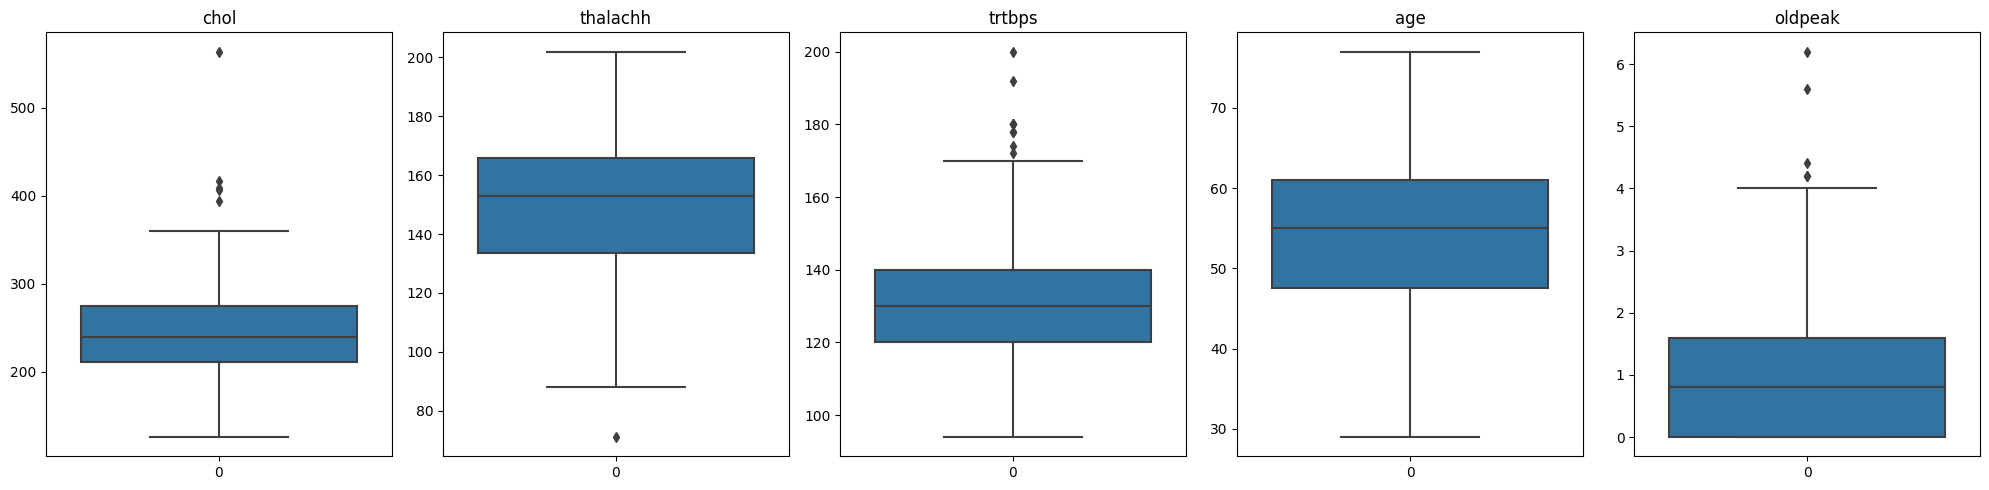

In [7]:
def detect_and_plot_outliers(df, variable, ax):
    
    # Calcular los límites utilizando el rango intercuartílico (IQR)
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar los outliers
    outliers = df[(df[variable] < lower_bound) | (df[variable] > upper_bound)]

    # Generar un box plot para visualizar los outliers
    sns.boxplot(df[variable], ax=ax, orient='v')  # orient='v' for vertical boxplot
    ax.set_title(variable)

    # Calcular la media de los outliers si existen
    outliers_mean = outliers[variable].mean() if not outliers.empty else np.nan
    outliers_mean = round(outliers_mean, 2)

    # Substituir NaN en outliers_mean por 0 si no hay outliers
    if np.isnan(outliers_mean):
        outliers_mean = 0

    return {"variable": variable, "n_outliers": len(outliers), "outliers_mean": outliers_mean, "lower_bound": lower_bound, "upper_bound": upper_bound, "outliers": outliers}


# Crear una figura con 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Aplicar la función a todas las variables numéricas y mostrar los outliers
outliers_df = pd.DataFrame([detect_and_plot_outliers(df_cleaned, var, ax) for var, ax in zip(numerical_vars, axes.flatten())])

# Formatear las mayúsculas de la variable y de las columnas
outliers_df['variable'] = outliers_df['variable'].str.capitalize()
outliers_df.columns = outliers_df.columns.str.capitalize()

# Imprimir el resumen de los outliers centrado
display(outliers_df.drop("Outliers", axis=1)) # Dropeamos la columna "outliers" para que no se muestre en el resumen

plt.tight_layout()
plt.show()

A continuación, se muestra un resumen de las variables con outliers y la cantidad de outliers detectados en cada una:

- Variable 'chol': 5 outliers.
- Variable 'thalachh': 1 outlier.
- Variable 'trtbps': Se encontraron 9 outliers.
- Variable 'oldpeak': Se encontraron 5 outliers.

Estos outliers pueden indicar valores extremadamente altos o bajos en las respectivas variables y podrían tener un impacto en el análisis y los modelos posteriores. Algunas posibles acciones que se pueden considerar para tratar los outliers son:

- Retener los outliers: En algunos casos, los outliers pueden ser valores legítimos y representar situaciones excepcionales o datos inusuales pero válidos. En este enfoque, se puede optar por no eliminarlos y mantenerlos en el conjunto de datos.

- Eliminar los outliers: Si se considera que los outliers son datos atípicos o errores, se puede optar por eliminarlos del conjunto de datos. Esto puede ayudar a evitar que los outliers distorsionen los resultados y afecten el rendimiento del modelo.

- Transformar los valores: En lugar de eliminar o retener los outliers, se pueden aplicar transformaciones a los datos para reducir su impacto. Por ejemplo, se puede utilizar la transformación logarítmica o la escala robusta para ajustar los valores y disminuir la influencia de los outliers.

- Utilizar técnicas de imputación: En algunos casos, puede ser apropiado reemplazar los outliers por valores imputados basados en métodos como la media, la mediana o la interpolación.

La elección de la acción a tomar dependerá del contexto del análisis, el conocimiento del dominio y los objetivos específicos del estudio. Es importante evaluar cuidadosamente cada opción y considerar las implicaciones que pueda tener en el análisis y los resultados.

### Gestión de los outliers

En nuestro caso concreto, consideramos que las acciones que deberíamos tomar para cada caso son:
* __Chol__: Esta variable representa el colesterol sérico en mg/dl. Los outliers identificados tienen un valor medio de 438.20, que está considerablemente por encima del límite superior de 369.75. Esto puede ser debido a condiciones de salud extremas o a errores de medición. En este caso, lo que deberíamos hacer es investigar cada caso particular o consultar a un experto en la materia para saber si estos casos pueden ser casos reales de personas con el colesterol extremadamente alto. Como no tenemos medios para ello, supondremos que estos casos son reales de personas con hipercolesterolemia.

* __Thalachh__: Este es el máximo ritmo cardíaco alcanzado por un paciente. El outlier detectado es un valor de 71, que está por debajo del límite inferior de 84.75. Este valor extremadamente bajo puede deberse a condiciones de salud graves. En este caso, podría ser importante retener este valor, ya que podría aportar información relevante en el análisis de las enfermedades cardíacas. Este valor además, aunque es bajo para nuestro análisis, nos cuadra que podría ser el de, por ejemplo, un deportista de alto rendimiento de disciplinas como el ciclismo, cuyos ritmos cardíacos son anormalmente bajos.

* __Trtbps__: Este es la presión arterial en reposo. Los outliers identificados tienen un valor medio de 181.56, que está por encima del límite superior de 170. Esto podría ser debido a condiciones de salud extremas. Aquí, de nuevo, deberíamos consultar a un experto o investigar el origen de los datos. Sin ser expertos en la materia, hemos realizado una mínima investigación y vemos que esto puede coincidir con personas que estén sufriendo una crisis hipertensiva, por lo cual los outliers podrían ser reales.

* __Oldpeak__: Esta variable mide la depresión del ST inducida por el ejercicio en relación con el reposo. Los outliers identificados tienen un valor medio de 4.92, que está por encima del límite superior de 4.00. En este caso, aunque de nuevo no tenemos medios para identificar si son datos reales o no, supondremos que hemos contactado con un especialista y nos ha indicado que aquellos valores por encima de 5 deben ser falsos. Hacemos esto con el objetivo de gestionar algunos outliers de cara a la práctica. Por ende, en este caso los sustituiremos por la variable de la mediana.

,Variable,N_outliers,Outliers_mean,Lower_bound,Upper_bound
0,Chol,5,438.20,115.75,369.75
1,Thalachh,1,71.00,84.75,214.75
2,Trtbps,9,181.56,90.00,170.00
3,Age,0,0.00,27.25,81.25
4,Oldpeak,3,4.27,-2.40,4.00


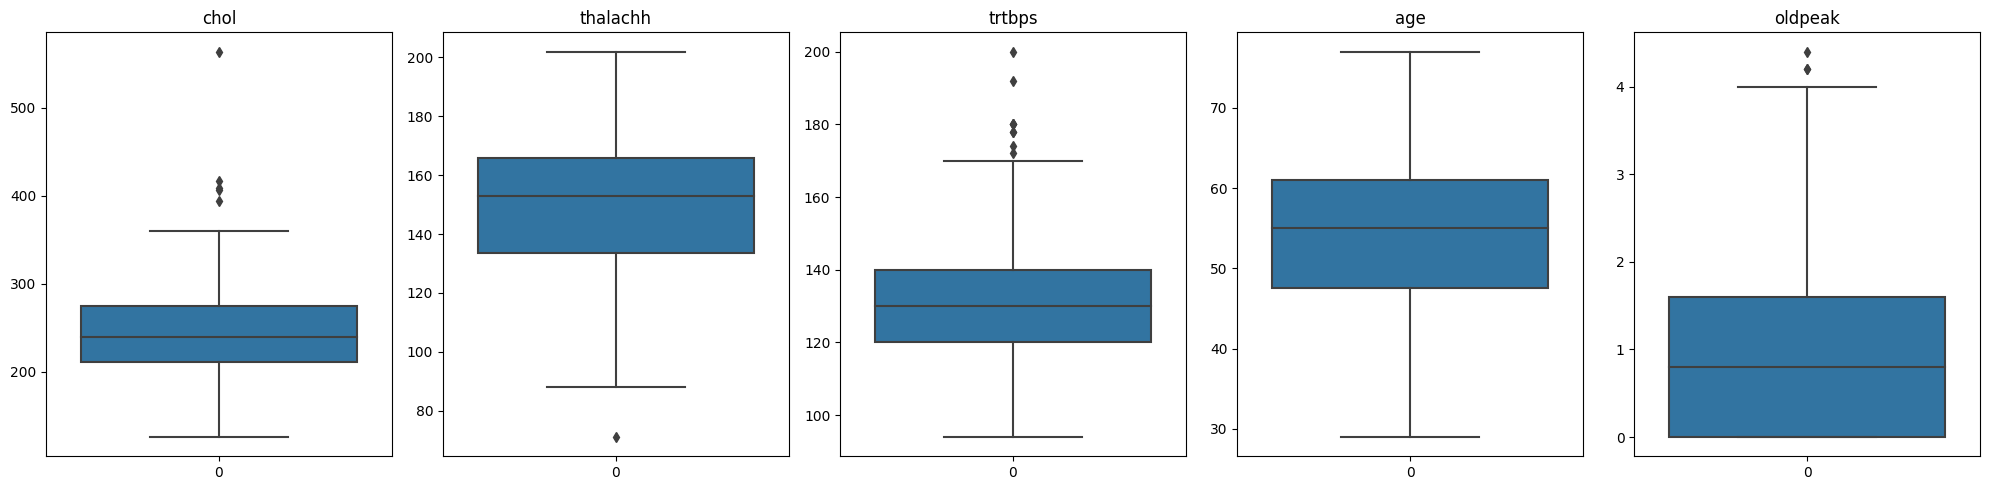

In [8]:
# Gestión de outliers, suponiendo que oldpeak es la única variable con falsos outliers

# Reemplazar los outliers por el valor de la mediana si están por encima de 5
df_cleaned.loc[df_cleaned['oldpeak'] > 5, 'oldpeak'] = df_cleaned['oldpeak'].median()

# Volvemos a llamar a detect_and_plot_outliers para mostrar los outliers reales tras la gestión de los mismos
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
outliers_df = pd.DataFrame([detect_and_plot_outliers(df_cleaned, var, ax) for var, ax in zip(numerical_vars, axes.flatten())])
outliers_df['variable'] = outliers_df['variable'].str.capitalize()
outliers_df.columns = outliers_df.columns.str.capitalize()
display(outliers_df.drop("Outliers", axis=1))
plt.tight_layout()
plt.show()

# 4. Análisis de los datos

## Análisis descriptivo

Antes de adentrarnos en el análisis puramente estadístico, es crucial entender las características básicas de nuestros datos. Un análisis exploratorio inicial nos puede proporcionar una visión general sobre la distribución de nuestras variables categóricas y numéricas, incluyendo la variable objetivo (output).

En los siguientes bloques de código, generaremos gráficos para cada una de nuestras variables categóricas. En estos gráficos, el eje horizontal representa las diferentes categorías dentro de cada variable y el eje vertical muestra la cantidad de observaciones en cada categoría. Además, cada gráfico está coloreado según los valores de la variable objetivo, lo que nos permite observar rápidamente cómo la variable objetivo se distribuye en relación con nuestras variables categóricas.

Estos gráficos nos ayudarán a identificar patrones y anomalías que podrían ser relevantes para nuestro análisis posterior. Así mismo, nos permitirán verificar si los datos han sido correctamente limpiados y preparados para el análisis estadístico.

### Análisis visual de la distribución de la variable output (ataque al corazón)

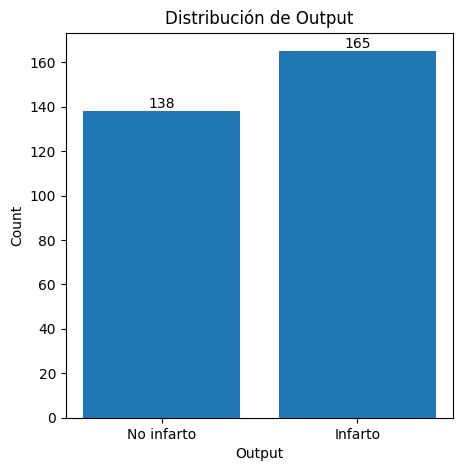

,proportion
Infarto,54.46%
No infarto,45.54%


In [9]:
# Calcular la distribución de la variable "output"
output_counts = df_cleaned['output'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(5, 5))
bars = plt.bar(output_counts.index, output_counts.values) 

# Configurar etiquetas y título
plt.xlabel('Output')
plt.ylabel('Count')
plt.title('Distribución de Output')

# Configurar el rango y las etiquetas del eje x
label_mapping = {0: 'No infarto', 1: 'Infarto'}
plt.xticks(output_counts.index, [label_mapping[val] for val in output_counts.index])

# Mostrar el recuento en la parte superior de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center') 

# Mostrar el gráfico
plt.show()

# Mostrar porcentajes
output_percentages = df_cleaned.output.value_counts(1).apply(lambda x: "{:.2%}".format(x))
output_percentages.index = [label_mapping[val] for val in output_percentages.index]
display(pd.DataFrame(output_percentages))

Basándonos en los datos, se observa una distribución cercana al equilibrio en la variable de salida "output", la cual identifica si se produjo un infarto. El 54.46% de las observaciones corresponden a casos de infarto (valor "1"), mientras que el 45.54% restante representa casos en los que no ocurrió un infarto (valor "0").

Esta distribución, aunque no perfectamente balanceada, no presenta un desbalance extremo. Hay una ligera prevalencia de casos de infarto sobre los casos sin infarto. Sin embargo, la diferencia no es lo suficientemente significativa como para considerarla desbalanceada a efectos prácticos en la mayoría de los análisis y modelos estadísticos.

Por lo tanto, la variable objetivo "output" proporciona una representación razonablemente equilibrada de los dos posibles escenarios de interés en este conjunto de datos: la presencia o ausencia de un infarto. Esto significa que este dataset podría ser utilizado en el contexto de un modelo de predicción, puesto no se sesgarían el análisis en gran medida hacia un resultado concreto.

### Análisis visual de la relación entre variables categóricas y los ataques al corazón

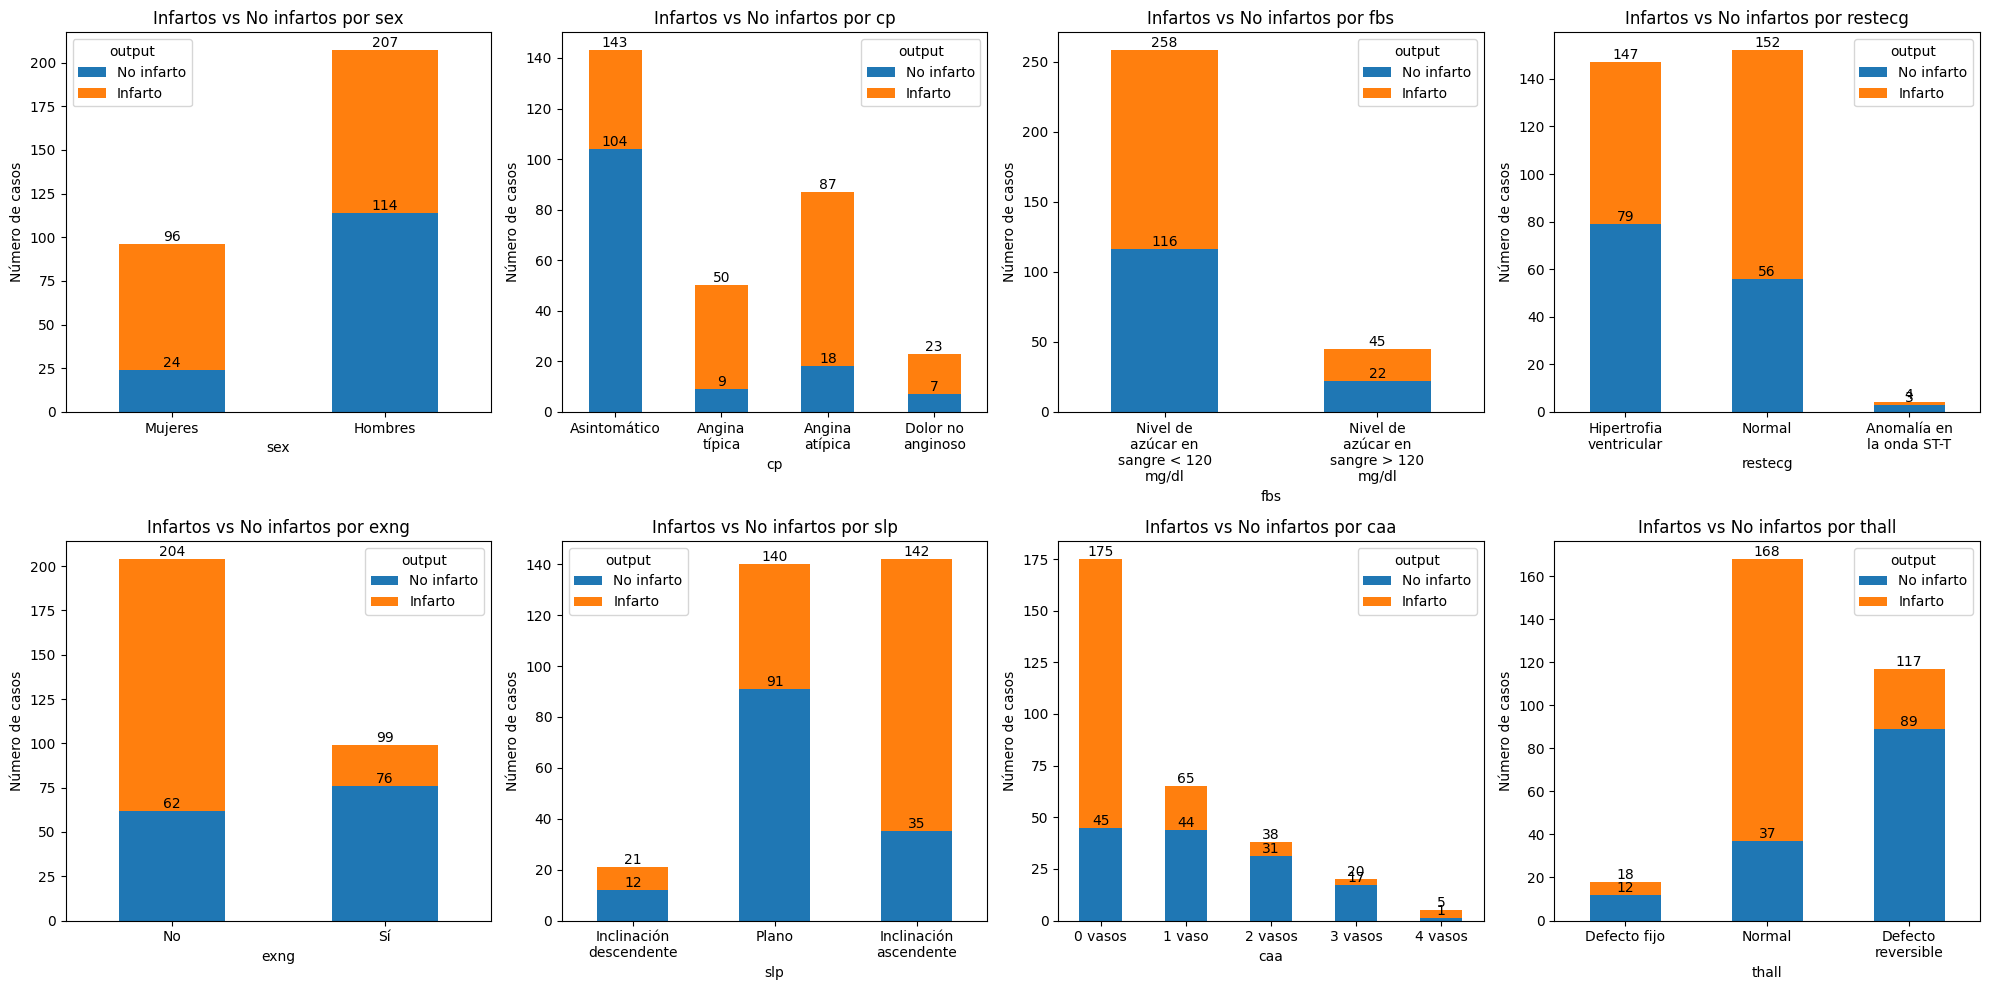

output,No infarto,Infarto
sex,,
Mujeres,24,72
Hombres,114,93
output,No infarto,Infarto
cp,,
Asintomático,104,39
Angina típica,9,41
Angina atípica,18,69
Dolor no anginoso,7,16
output,No infarto,Infarto


In [10]:
# Definir la variable objetivo
target_var = 'output'

# Diccionario con las etiquetas personalizadas para cada variable categórica
labels_dict = {
    'sex': {0: 'Mujeres', 1: 'Hombres'},
    'cp': {1: 'Angina típica', 2: 'Angina atípica', 3: 'Dolor no anginoso', 0: 'Asintomático'},
    'fbs': {0: 'Nivel de azúcar en sangre < 120 mg/dl', 1: 'Nivel de azúcar en sangre > 120 mg/dl'},
    'restecg': {1: 'Normal', 2: 'Anomalía en la onda ST-T', 0: 'Hipertrofia ventricular'},
    'exng': {0: 'No', 1: 'Sí'},
    'slp': {0: 'Inclinación descendente', 1: 'Plano', 2: 'Inclinación ascendente'},
    'caa': {0: '0 vasos', 1: '1 vaso', 2: '2 vasos', 3: '3 vasos', 4: '4 vasos'},
    'thall': {1: 'Defecto fijo', 2: 'Normal', 3: 'Defecto reversible'},
    'output': {0: 'No infarto', 1: 'Infarto'}
}

# Número de filas y columnas para los subplots
n_rows = int(np.ceil(len(categorical_vars) / 4))
n_cols = min(len(categorical_vars), 4)

# Crear una figura para todos los subplots
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*5))

# Aplanar los ejes para iterar sobre ellos
ax = ax.ravel()

# Iterar sobre las variables categóricas y los ejes
for var, axis in zip(categorical_vars, ax):
    # Calcular el recuento de infartos y no infartos en cada categoría
    counts = df_cleaned.groupby([var, target_var]).size().unstack().fillna(0)

    # Cambiar los valores de todas las columnas según labels_dict
    counts.rename(columns=labels_dict['output'], inplace=True)

    # Crear el gráfico de barras en el subplot correspondiente
    counts.plot(kind='bar', stacked=True, ax=axis)

    # Configurar etiquetas y título 
    axis.set_xlabel(var)
    axis.set_ylabel('Número de casos')
    axis.set_title('Infartos vs No infartos por {}'.format(var))

    # Obtener las etiquetas para el eje x
    labels = counts.index

    # Verificar si la variable tiene etiquetas personalizadas en el diccionario y reemplazar las etiquetas correspondientes
    if var in labels_dict:
        labels = [labels_dict[var].get(label, label) for label in labels]

    # Ajustar las etiquetas para que no se superpongan
    labels = ['\n'.join(textwrap.wrap(lab, 12)) for lab in labels]
    axis.set_xticklabels(labels, rotation= 0)

    # Agregar los data labels para cada barra
    for container in axis.containers:
        axis.bar_label(container)

plt.tight_layout()
plt.show()

# Crear una lista para almacenar los recuentos de cada variable categórica
html_str = []

for var in categorical_vars:
    # Calcular el recuento de infartos y no infartos en cada categoría
    counts = df_cleaned.groupby([var, target_var]).size().unstack().fillna(0)

    # Cambiar los valores de todas las columnas según labels_dict
    counts.rename(columns=labels_dict['output'], inplace=True)
    counts.rename(index=labels_dict[var], inplace=True)

    # Crear una tabla HTML con los recuentos
    html_str.append('<div style="width: 100%; text-align: center;"><h3>Tabla de recuentos para {}:</h3><div style="display: inline-block">{}</div></div>'.format(var, counts.to_html()))

# Unir las tablas HTML en una sola cadena
html_str = ''.join(['<div style="display: inline-block; width: 23%; margin: 1%; vertical-align: top;">{}</div>'.format(h) 
                    for h in html_str])

display(HTML(html_str))

Acerca de la distribución de nuestras variables categóricas:

- __sex__: los hombres son más del doble que las mujeres, y la probabilidad de tener un infarto es mayor en las mujeres.
- __fbs__: la mayoría de las personas de la muestra no tienen azúcar en sangre, y no tiene gran incidencia en la probabilidad de tener infartos.
- __exng__: es más probable que las personas no tengan angina inducida por el ejercicio, y la probabilidad de tener un infarto en estos es mayor.
- __restecg__ (resultados electrocardiográficos en reposo): las proporciones de personas con resultados normales (valor 0) y con anomalías en la onda ST-T (valor 1) están bastante equilibradas, mientras que hay un pequeño porcentaje de personas con hipertrofia ventricular (valor 2)
- __cp__ (tipo de dolor torácico): la proporción de personas asintomáticas (valor 0) es la más alta (aproximadamente 50%), mientras que la proporción de personas que tienen dolor no anginoso (valor 3) es la más baja. La probabilidad de tener un infarto es menor en las personas asintomáticas.
- __slp__ (la pendiente del segmento ST del ejercicio máximo): las proporciones de personas con resultados planos (valor 2) y con inclinación ascendente (valor 1) están bastante equilibradas, mientras que hay un pequeño porcentaje de personas con inclinicación descendente (valor 0)
- __caa__: las proporciones de personas baja según aumenta el número de vasos principales coloreados por fluoroscopia.
- __thall__: la mayoría de las personas tienen un resultado normal en la prueba de esfuerzo con talio (valor 2), seguido de cerca por resultado con defecto reversible, siendo la proporción de personas con defecto fijo la más baja. Por otro lado, la probabilidad de tener infartos es mayoyr en los resultados normales.

### Análisis visual de la relación entre variables numéricas y los ataques al corazón

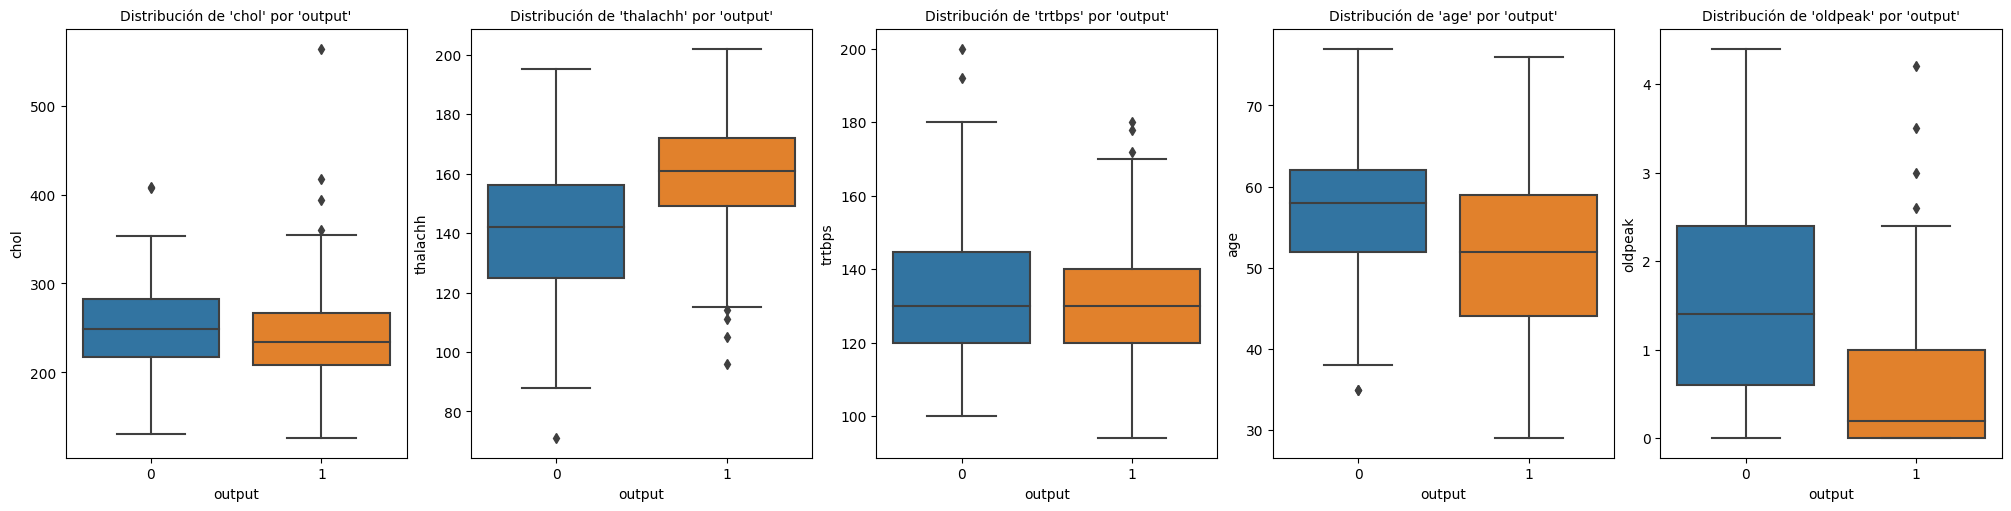

In [11]:
# Generación de gráficos para analizar las variables numéricas

n_vars = len(numerical_vars)
n_cols = 5
n_rows = 1

# Crear un objeto figura con varios subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), constrained_layout=True)

# Aplanar el array de ejes para poder iterar sobre él
axes = axes.ravel()

# Tamaño de fuente para los títulos de los gráficos
font_size = 10

# Iterar sobre las variables numéricas y mostrar la distribución de la variable target.
for i, var in enumerate(numerical_vars):
    ax = axes[i]
    sns.boxplot(x=target_var, y=var, data=df_cleaned, ax=ax)
    ax.set_title(f"Distribución de '{var}' por '{target_var}'", fontsize=font_size)
    ax.tick_params(labelsize=font_size)

plt.show()

Acerca de la distribución de nuestras variables numéricas, podemos decir:

- __chol__: La concentración de colesterol en la sangre parece variar de forma significativa entre los pacientes, con una media de 246.26 mg/dl. Aunque no se percibe una clara distinción entre aquellos que han sufrido un infarto y los que no, los valores extremadamente altos (como el máximo registrado de 564 mg/dl) podrían estar asociados con un mayor riesgo de enfermedad cardíaca.

- __thalachh__: La frecuencia cardíaca máxima alcanzada (thalachh) tiene una media de 149.65 latidos por minuto, con un rango de 71 a 202. Si bien hay una tendencia a una mayor frecuencia cardíaca en personas que han sufrido un infarto, la relación no es absoluta, ya que la variabilidad entre los pacientes es alta. Vale la pena mencionar que alcanzar una frecuencia cardíaca máxima muy baja (como el mínimo registrado de 71) podría ser un indicador de riesgo.

- __trtbps__: La presión arterial en reposo tiene una media de 131.62 mm Hg, con un rango que va desde 94 hasta 200 mm Hg. Aunque no parece haber una gran diferencia entre los pacientes que han sufrido un infarto y los que no, los valores extremadamente altos podrían ser un indicador de riesgo.

- __age__: La media de edad es de 54.37 años, con un rango de 29 a 77 años. Si bien la edad puede ser un factor de riesgo para enfermedades cardíacas, no se observa un patrón claro que indique una mayor prevalencia de infartos en los grupos de mayor edad.

- __oldpeak__: En promedio, el valor de la depresión del ST inducida por el ejercicio en relación con el reposo es de 1.01. Aunque valores más bajos parecen estar asociados con una mayor probabilidad de sufrir un infarto, la variabilidad entre los pacientes es alta (desviación estándar de 1.09), lo que sugiere que otros factores pueden estar también en juego.

### Análisis estadístico descriptivo

In [12]:
# Obtener estadísticas descriptivas de las variables numéricas
df_numerical = df_cleaned[numerical_vars]  # Filtrar solo las columnas numéricas de interés
display(pd.DataFrame(df_numerical.describe().apply(lambda x: round(x, 2))))  # Redondear a 2 decimales

,chol,thalachh,trtbps,age,oldpeak
count,303.00,303.00,303.00,303.00,303.00
mean,246.26,149.65,131.62,54.37,1.01
std,51.83,22.91,17.54,9.08,1.09
min,126.00,71.00,94.00,29.00,0.00
25%,211.00,133.50,120.00,47.50,0.00
50%,240.00,153.00,130.00,55.00,0.80
75%,274.50,166.00,140.00,61.00,1.60
max,564.00,202.00,200.00,77.00,4.40


Interpretación:
- ___Colesterol ('chol')___: El promedio de colesterol es de 246.26 mg/dl, lo cual indica que en general los pacientes tienden a tener niveles moderados de colesterol. Los valores varían desde 126 hasta 564 mg/dl, lo que muestra una amplia variabilidad en los niveles de colesterol en la muestra.
- ___Frecuencia cardíaca máxima alcanzada ('thalachh')___: La media de la frecuencia cardíaca máxima es de 149.65, lo cual sugiere una capacidad moderada de los pacientes para alcanzar una frecuencia cardíaca máxima durante el ejercicio. Los valores oscilan entre 71 y 202, mostrando una amplia gama de frecuencias cardíacas máximas registradas.
- ___Presión arterial en reposo ('trtbps')___: El valor promedio de la presión arterial en reposo es de 131.62 mm Hg, lo que indica una presión arterial en reposo en un rango normal. Los valores varían desde 94 hasta 200 mm Hg, mostrando cierta variabilidad en los niveles de presión arterial en la muestra.
- ___Edad ('age')___: La media de edad de los pacientes es de 54.37 años, lo cual indica que la muestra incluye a pacientes de mediana edad. Los valores varían desde 29 hasta 77 años, mostrando una amplia gama de edades representadas.
- ___Depresión del segmento ST inducida por el ejercicio ('oldpeak')___: El valor promedio de la depresión del segmento ST es de 1.01, lo que sugiere una presencia moderada de cambios en el electrocardiograma después del ejercicio. Los valores varían desde 0 hasta 5 (tras la eliminación de falsos outliers), mostrando una amplia variabilidad en la magnitud de la depresión del segmento ST.

# Análisis estadístico inferencial

## Modelos no supervisados

### Pruebas de contraste de hipótesis
Para realizar las pruebas de hipótesis, es recomendable que los datos cumplan con los supuestos de normalidad y homogeneidad de varianzas. Sin embargo, en muestras grandes (como en este caso, con 303 registros), las pruebas pueden ser menos sensibles a estos supuestos y pueden ofrecer resultados confiables.

#### Normalidad
Para verificar la normalidad, hemos usado gráficos de histogramas y gráficos Q-Q (quantile-quantile) para visualizar la distribución de los datos. Además, hemos aplicado la prueba de normalidad de Shapiro-Wilk para obtener evidencia cuantitativa de la normalidad de los datos. Para que la variable siga una distribución normal, el valor de p debe ser superior al nivel de significancia, en nuestro caso, 0.05.

#### Homocedasticidad
Además, hemos aplicado la prueba de Levene para evaluar si existen diferencias significativas en las varianzas entre los grupos. En esta prueba, un valor de p por debajo del nivel de significancia elegido (comúnmente 0.05) indica que las varianzas de los grupos son significativamente diferentes, lo que viola el supuesto de homocedasticidad.

En el contexto de este estudio, cuyo objetivo principal es predecir la probabilidad de sufrir un ataque al corazón basado en diversas características, es crucial evaluar la homocedasticidad. Algunas pruebas interesantes que podrías considerar son:

In [13]:
group1 = df_cleaned[df_cleaned[target_var] == 0]
group2 = df_cleaned[df_cleaned[target_var] == 1]

#### Edad (age)
Comparamos la edad (Age) promedio entre los pacientes con menor probabilidad de sufrir un ataque al corazón (target = 0) y los pacientes con mayor probabilidad de sufrir un ataque al corazón (target = 1). Esto podría ayudar a determinar si existe una diferencia significativa en la edad entre los dos grupos.

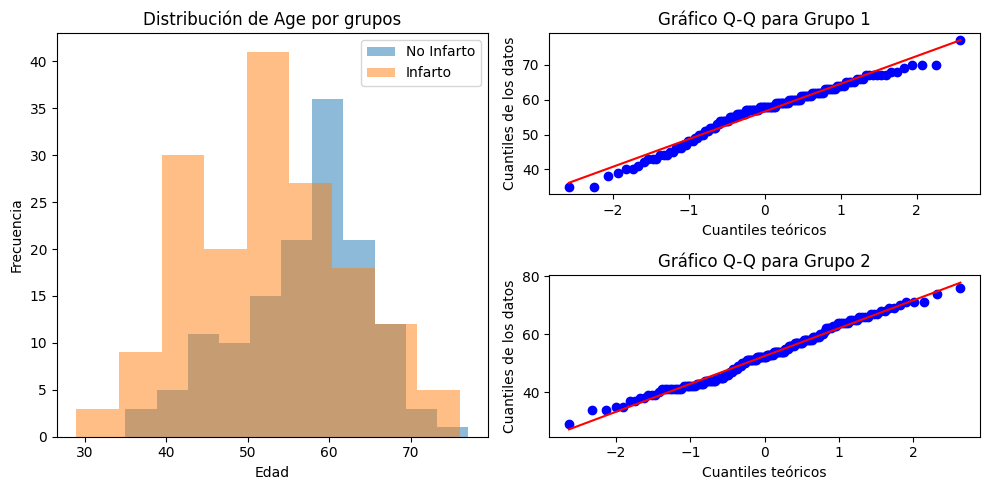

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.002868662355467677
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.12113280594348907


In [44]:
# Realizar pruebas de normalidad
group1_age = group1['age']
group2_age = group2['age']

# Verificación de la normalidad
plt.figure(figsize=(10, 5))

# Histogramas
plt.subplot(1, 2, 1)
plt.hist(group1_age, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_age, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Age por grupos')
plt.legend()

# Gráfico Q-Q
plt.subplot(2, 2, 2)
stats.probplot(group1_age, dist='norm', plot=plt)
plt.title('Gráfico Q-Q para Grupo 1')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los datos')

plt.subplot(2, 2, 4)
stats.probplot(group2_age, dist='norm', plot=plt)
plt.title('Gráfico Q-Q para Grupo 2')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los datos')

plt.tight_layout()
plt.show()

_, p_value1 = stats.shapiro(group1_age)
_, p_value2 = stats.shapiro(group2_age)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Los resultados de la prueba de normalidad (Shapiro-Wilk) indican que para el grupo 1, la variable 'Age' no sigue una distribución normal (p-value = 0.0029 < 0.05), mientras que para el grupo 2, la variable 'Age' sí sigue una distribución normal (p-value = 0.1211 > 0.05). Esto sugiere que el grupo 1 no cumple con el supuesto de normalidad, mientras que el grupo 2 sí cumple con este supuesto.

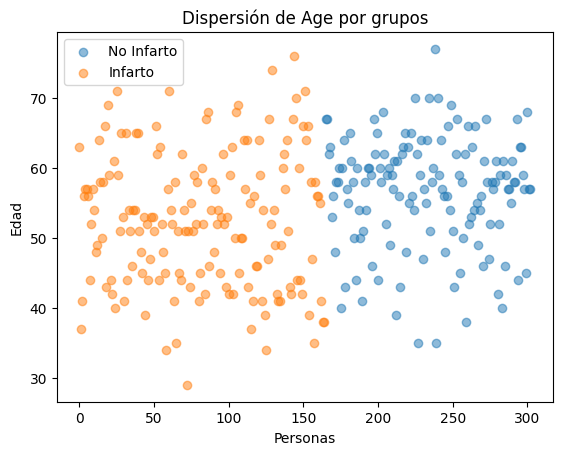

Prueba de homogeneidad de varianzas (Levene): p-value = 0.005030946112241477


In [57]:
# Verificación de homogeneidad de varianzas
plt.figure()
plt.scatter(group1.index, group1_age, alpha=0.5, label='No Infarto')
plt.scatter(group2.index, group2_age, alpha=0.5, label='Infarto')
plt.xlabel('Personas')
plt.ylabel('Edad')
plt.title('Dispersión de Age por grupos')
plt.legend()
plt.show()

_, p_value = stats.levene(group1_age, group2_age)
print('Prueba de homogeneidad de varianzas (Levene): p-value =', p_value)

El resultado de la prueba de homogeneidad de varianzas (Levene) indica que existe una diferencia significativa en las varianzas entre los dos grupos (p-value = 0.0050 < 0.05). Esto significa que __no se cumple el supuesto de homogeneidad__ de varianzas en este caso.

Dado que tanto ___el supuesto de normalidad como el supuesto de homogeneidad de varianzas no se cumplen___ en este análisis, podríamos optar por utilizar una alternativa no paramétrica, como las pruebas de Wilcoxon o Mann-Whitney, pero esto generalmente implica la pérdida de potencia estadística. Por ello, existe otra alternativa previa al uso de pruebas no paramétricas que consiste en convertir los datos para tratar de mejorar su normalidad y homocedasticidad: la ___transformación de Box-Cox___.

Vamos a aplicar este método a nuestro dataset: 

In [16]:
# Transformación de Box-Cox en 'Age'
age_transformed, lambda_val = stats.boxcox(df_cleaned['age'])

# Separar los grupos basados en la variable 'output'
group1_age_transformed = age_transformed[df_cleaned[target_var] == 0]
group2_age_transformed = age_transformed[df_cleaned[target_var] == 1]

# Imprimir el valor óptimo de lambda
print("Valor óptimo de lambda:", lambda_val)

Valor óptimo de lambda: 1.4117531035524666


Ahora que hemos realizado la transformación de Box-Cox en la variable 'age', podemos volver a comprobar las pruebas de normalidad y homogeneidad de varianzas en los datos transformados y en caso de que se cumplan, aplicar las pruebas paramétricas, como la prueba t de Student:

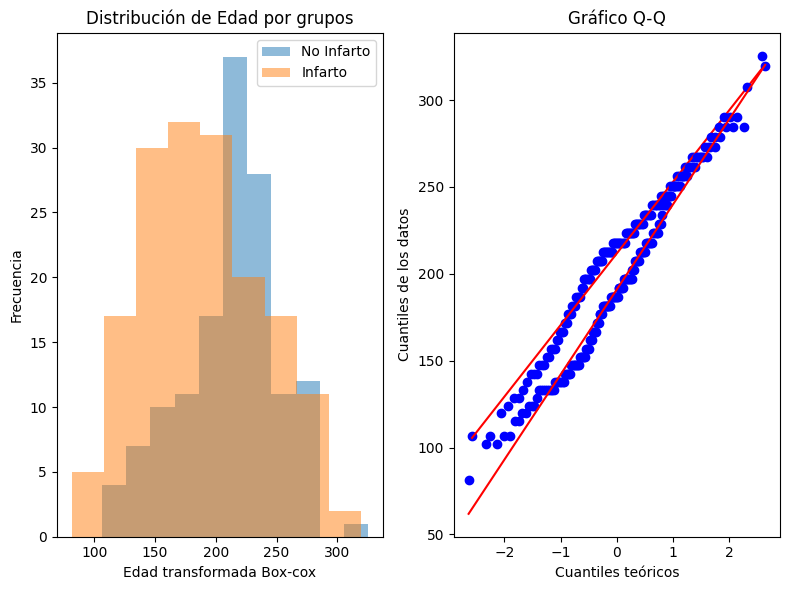

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.021911008283495903
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.030841266736388206


In [17]:
# Verificación de la normalidad
plt.figure(figsize=(8, 6))

# Histogramas
plt.subplot(1, 2, 1)
plt.hist(group1_age_transformed, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_age_transformed, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Edad transformada Box-cox')
plt.ylabel('Frecuencia')
plt.title('Distribución de Edad por grupos')
plt.legend()

# Gráfico Q-Q
plt.subplot(1, 2, 2)
stats.probplot(group1_age_transformed, dist='norm', plot=plt)
stats.probplot(group2_age_transformed, dist='norm', plot=plt)
plt.title('Gráfico Q-Q')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los datos')

plt.tight_layout()
plt.show()

_, p_value1 = stats.shapiro(group1_age_transformed)
_, p_value2 = stats.shapiro(group2_age_transformed)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Después de aplicar la transformación de Box-Cox a la variable "age", los resultados de las pruebas de normalidad (Shapiro-Wilk) son los siguientes:

- Para el grupo 1 (No Infarto): p-value = 0.0219
- Para el grupo 2 (Infarto): p-value = 0.0308

Estos valores de p son menores que el nivel de significancia comúnmente utilizado (0.05), lo que sugiere que ___los datos transformados no siguen tampoco una distribución normal___ en ninguno de los grupos, por lo que es recomendable utilizar pruebas no paramétricas, como la prueba U de Mann-Whitney (no requiere el supuesto de normalidad ni el supuesto de homogeneidad de varianzas):

In [18]:
# Prueba U de Mann-Whitney
statistic, p_value = mannwhitneyu(group1_age, group2_age)
print('Prueba U de Mann-Whitney (Age):')
print('Estadístico U =', statistic)
print('Valor p =', p_value)

Prueba U de Mann-Whitney (Age):
Estadístico U = 14529.5
Valor p = 3.4385103183228994e-05


El resultado de la prueba U de Mann-Whitney para la variable 'Age' indica que hay una diferencia significativa en la edad promedio entre los dos grupos (p-value = 1.719e-05 < 0.05). Esto sugiere que ___la edad puede ser un factor importante en la probabilidad de sufrir un ataque al corazón___.

#### Colesterol (chol)
Comparamos el colesterol (chol) promedio entre los pacientes con menor probabilidad de sufrir un ataque al corazón (target = 0) y los pacientes con mayor probabilidad de sufrir un ataque al corazón (target = 1). Esto podría ayudar a determinar si existe una diferencia significativa en el índice de colesterol entre los dos grupos.

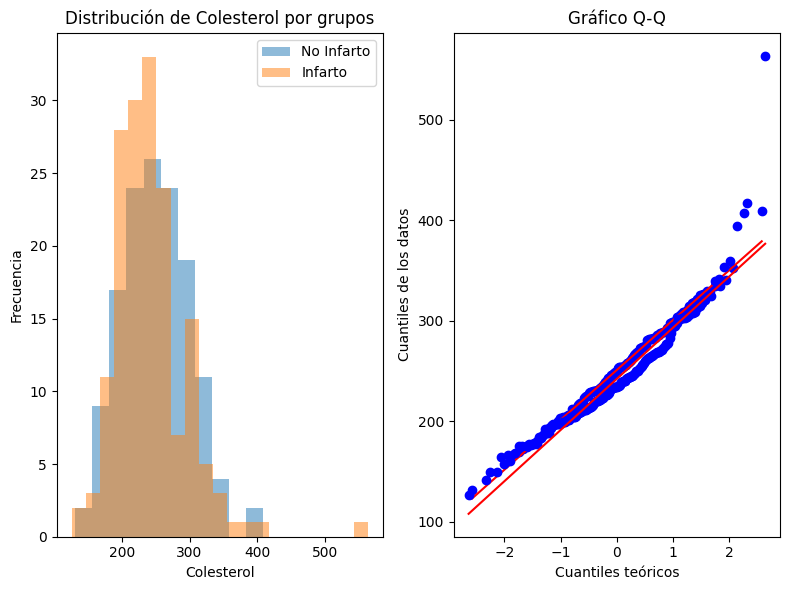

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.37918350100517273
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 3.078702404124556e-09


In [19]:
# Realizar pruebas de normalidad
group1_chol = group1['chol']
group2_chol = group2['chol']

# Verificación de la normalidad
plt.figure(figsize=(8, 6))

# Histogramas
plt.subplot(1, 2, 1)
plt.hist(group1_chol, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_chol, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Colesterol')
plt.ylabel('Frecuencia')
plt.title('Distribución de Colesterol por grupos')
plt.legend()

# Gráfico Q-Q
plt.subplot(1, 2, 2)
stats.probplot(group1_chol, dist='norm', plot=plt)
stats.probplot(group2_chol, dist='norm', plot=plt)
plt.title('Gráfico Q-Q')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los datos')

plt.tight_layout()
plt.show()

_, p_value1 = stats.shapiro(group1_chol)
_, p_value2 = stats.shapiro(group2_chol)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Para el grupo 1 (menor probabilidad de sufrir un ataque al corazón), el valor p de la prueba de normalidad (Shapiro-Wilk) es 0.3792. Dado que este valor p es mayor que el nivel de significancia comúnmente utilizado (0.05), no tenemos suficiente evidencia para rechazar la hipótesis nula de normalidad. Por lo tanto, podemos considerar que ___la variable 'chol' en el grupo 1 sigue una distribución normal___.

Para el grupo 2 (mayor probabilidad de sufrir un ataque al corazón), el valor p de la prueba de normalidad (Shapiro-Wilk) es 3.0789e-09. Este valor p es menor que el nivel de significancia, lo que indica que tenemos suficiente evidencia para rechazar la hipótesis nula de normalidad. Por lo tanto, podemos concluir que ___la variable 'chol' en el grupo 2 no sigue una distribución normal___.

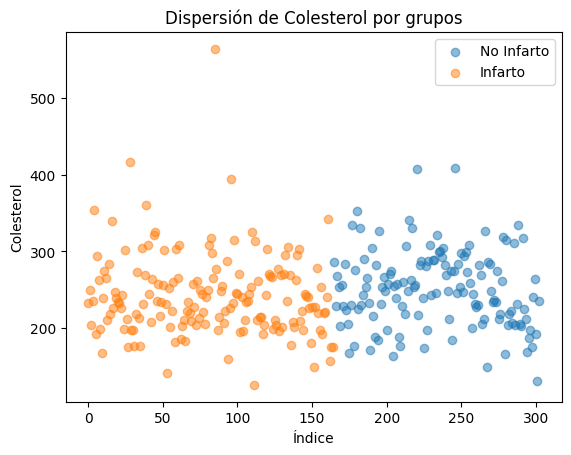

Prueba de homogeneidad de varianzas (Levene): p-value = 0.7503013119536838


In [20]:
# Verificación de homogeneidad de varianzas
plt.figure()
plt.scatter(group1.index, group1_chol, alpha=0.5, label='No Infarto')
plt.scatter(group2.index, group2_chol, alpha=0.5, label='Infarto')
plt.xlabel('Índice')
plt.ylabel('Colesterol')
plt.title('Dispersión de Colesterol por grupos')
plt.legend()
plt.show()

_, p_value = stats.levene(group1_chol, group2_chol)
print('Prueba de homogeneidad de varianzas (Levene): p-value =', p_value)

El resultado de la prueba de homogeneidad de varianzas (Levene) indica que no existe una diferencia significativa en las varianzas entre los dos grupos (p-value = 0.7503). Esto significa que ___se cumple el supuesto de homogeneidad de varianzas___.

Dado que tanto ___el supuesto de normalidad como el supuesto de homogeneidad de varianzas no se cumplen___ en este análisis, vamos a proceder como con la variable Age, realizaremos la ___transformación Box-cox___, primero:

In [21]:
# Transformación de Box-Cox en 'chol'
chol_transformed, lambda_val = stats.boxcox(df_cleaned['chol'])

# Separar los grupos basados en la variable 'target'
group1_chol_transformed = chol_transformed[df_cleaned[target_var] == 0]
group2_chol_transformed = chol_transformed[df_cleaned[target_var] == 1]

# Imprimir el valor óptimo de lambda
print("Valor óptimo de lambda:", lambda_val)

Valor óptimo de lambda: -0.10592568145157065


Ahora que hemos realizado la transformación de Box-Cox en la variable 'chol', podemos realizar las pruebas de normalidad y homogeneidad de varianzas en los datos transformados y luego aplicar las pruebas paramétricas, como la prueba t de Student:

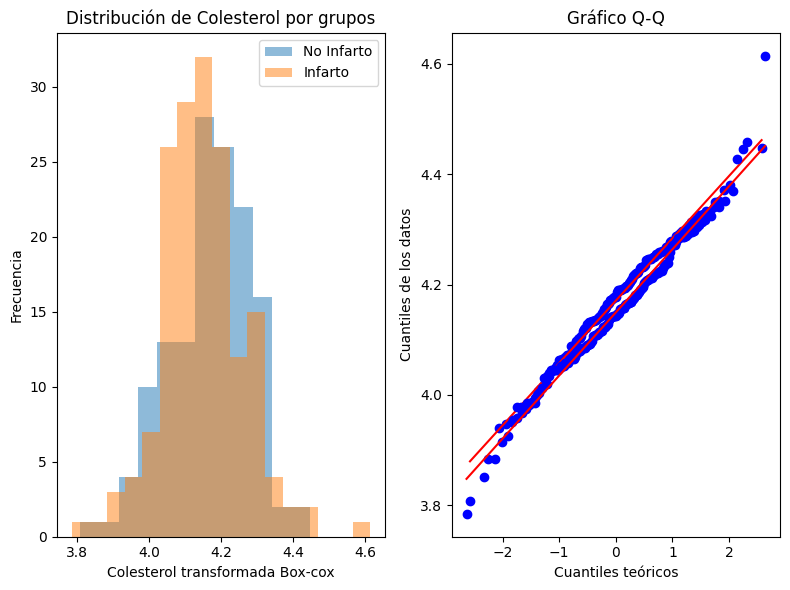

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.30135056376457214
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.03506076708436012


In [22]:
# Verificación de la normalidad
plt.figure(figsize=(8, 6))

# Histogramas
plt.subplot(1, 2, 1)
plt.hist(group1_chol_transformed, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_chol_transformed, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Colesterol transformada Box-cox')
plt.ylabel('Frecuencia')
plt.title('Distribución de Colesterol por grupos')
plt.legend()

# Gráfico Q-Q
plt.subplot(1, 2, 2)
stats.probplot(group1_chol_transformed, dist='norm', plot=plt)
stats.probplot(group2_chol_transformed, dist='norm', plot=plt)
plt.title('Gráfico Q-Q')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los datos')

plt.tight_layout()
plt.show()

_, p_value1 = stats.shapiro(group1_chol_transformed)
_, p_value2 = stats.shapiro(group2_chol_transformed)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Dado que los ___datos transformados de chol tampoco cumplen el supuesto de normalidad___, realizamos la prueba U de Mann-Whitney como alternativa a la prueba t de dos muestras independientes:

In [23]:
# Prueba U de Mann-Whitney
statistic, p_value = mannwhitneyu(group1_chol, group2_chol)
print('Prueba U de Mann-Whitney (chol):')
print('Estadístico U =', statistic)
print('Valor p =', p_value)

Prueba U de Mann-Whitney (chol):
Estadístico U = 12980.5
Valor p = 0.03571518201137641


Este resultado indica que hay una diferencia estadísticamente significativa en los niveles de colesterol promedio entre los grupos de pacientes con menor y mayor probabilidad de sufrir un ataque al corazón. El valor p es menor que el nivel de significancia comúnmente utilizado de 0.05, lo que sugiere que la diferencia observada en los niveles de colesterol entre los dos grupos no se puede atribuir al azar.

En resumen, este resultado indica que ___los niveles de colesterol pueden ser un factor importante en la probabilidad de sufrir un ataque al corazón___, ya que hay diferencias significativas en los niveles de colesterol promedio entre los grupos con menor y mayor probabilidad.

#### Presión arterial en reposo (trtbps).
Comparamos la presión arterial (trtbps) promedio entre los pacientes con menor probabilidad de sufrir un ataque al corazón (target = 0) y los pacientes con mayor probabilidad de sufrir un ataque al corazón (target = 1). Esto podría ayudar a determinar si existe una diferencia significativa entre los dos grupos.

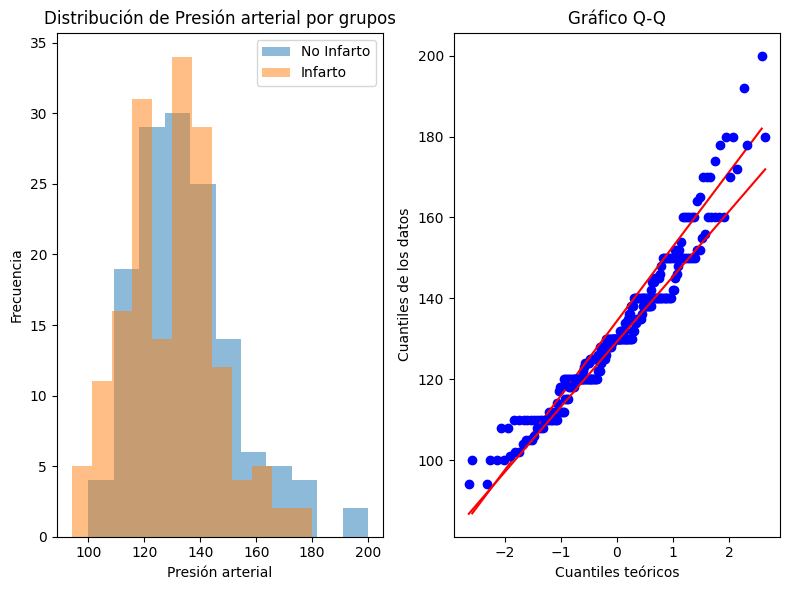

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 8.364587847609073e-05
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.011903473176062107


In [24]:
# Realizar pruebas de normalidad
group1_trtbps = group1['trtbps']
group2_trtbps = group2['trtbps']

# Verificación de la normalidad
plt.figure(figsize=(8, 6))

# Histogramas
plt.subplot(1, 2, 1)
plt.hist(group1_trtbps, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_trtbps, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Presión arterial')
plt.ylabel('Frecuencia')
plt.title('Distribución de Presión arterial por grupos')
plt.legend()

# Gráfico Q-Q
plt.subplot(1, 2, 2)
stats.probplot(group1_trtbps, dist='norm', plot=plt)
stats.probplot(group2_trtbps, dist='norm', plot=plt)
plt.title('Gráfico Q-Q')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los datos')

plt.tight_layout()
plt.show()

_, p_value1 = stats.shapiro(group1_trtbps)
_, p_value2 = stats.shapiro(group2_trtbps)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Los ___datos de trtbps no cumplen con la normalidad en ambos grupos___.

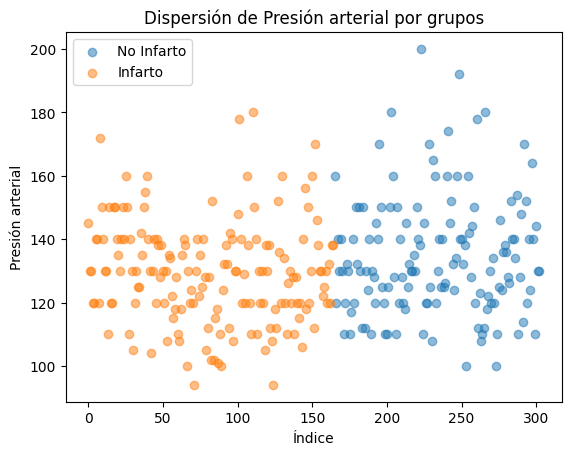

Prueba de homogeneidad de varianzas (Levene): p-value = 0.17399187776048733


In [25]:
# Verificación de homogeneidad de varianzas
plt.figure()
plt.scatter(group1.index, group1_trtbps, alpha=0.5, label='No Infarto')
plt.scatter(group2.index, group2_trtbps, alpha=0.5, label='Infarto')
plt.xlabel('Índice')
plt.ylabel('Presión arterial')
plt.title('Dispersión de Presión arterial por grupos')
plt.legend()
plt.show()

_, p_value = stats.levene(group1_trtbps, group2_trtbps)
print('Prueba de homogeneidad de varianzas (Levene): p-value =', p_value)

___Se cumple el supuesto de homogeneidad de varianzas en la variable trtbps___.

Pero dado que los datos de trtbps no cumplen con la normalidad en ambos grupos, vamos a realizar la transformación Box-cox:

In [26]:
# Transformación de Box-Cox en 'trtbps'
trtbps_transformed, lambda_val = stats.boxcox(df_cleaned['trtbps'])

# Separar los grupos basados en la variable 'target'
group1_trtbps_transformed = trtbps_transformed[df_cleaned[target_var] == 0]
group2_trtbps_transformed = trtbps_transformed[df_cleaned[target_var] == 1]

# Imprimir el valor óptimo de lambda
print("Valor óptimo de lambda:", lambda_val)

Valor óptimo de lambda: -0.6969418904300226


Ahora que hemos realizado la ___transformación de Box-Cox en la variable 'trtbps'___, podemos realizar las pruebas de normalidad y homogeneidad de varianzas en los datos transformados y luego aplicar las pruebas paramétricas, como la prueba t de Student:

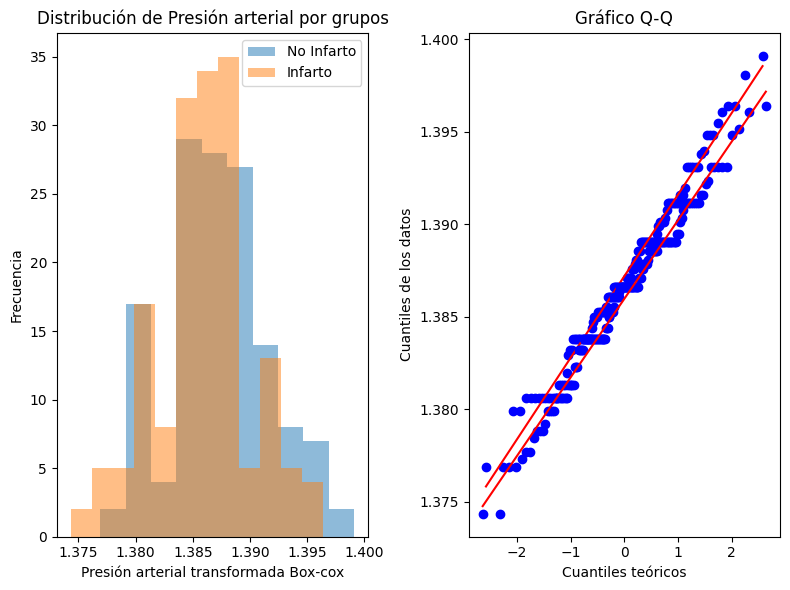

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.1968512237071991
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.08565879613161087


In [27]:
# Verificación de la normalidad
plt.figure(figsize=(8, 6))

# Histogramas
plt.subplot(1, 2, 1)
plt.hist(group1_trtbps_transformed, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_trtbps_transformed, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Presión arterial transformada Box-cox')
plt.ylabel('Frecuencia')
plt.title('Distribución de Presión arterial por grupos')
plt.legend()

# Gráfico Q-Q
plt.subplot(1, 2, 2)
stats.probplot(group1_trtbps_transformed, dist='norm', plot=plt)
stats.probplot(group2_trtbps_transformed, dist='norm', plot=plt)
plt.title('Gráfico Q-Q')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los datos')

plt.tight_layout()
plt.show()

_, p_value1 = stats.shapiro(group1_trtbps_transformed)
_, p_value2 = stats.shapiro(group2_trtbps_transformed)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

En ambos casos, los valores p son mayores que el nivel de significancia comúnmente utilizado de 0.05, lo que indica que ___los datos transformados de trtbps podrían seguir una distribución normal en ambos grupos___. 

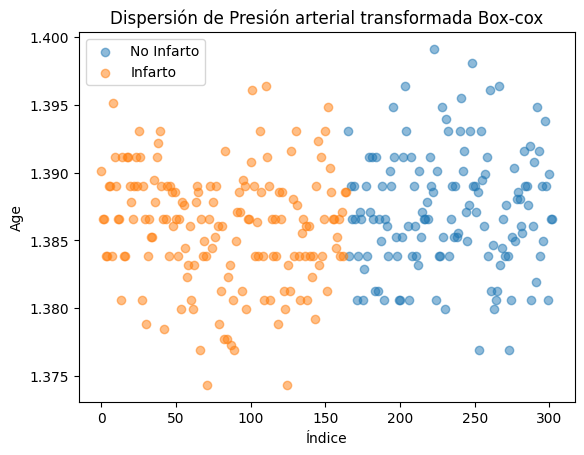

Prueba de homogeneidad de varianzas (Levene): p-value = 0.5746765109778355


In [28]:
# Verificación de homogeneidad de varianzas
plt.figure()
plt.scatter(group1.index, group1_trtbps_transformed, alpha=0.5, label='No Infarto')
plt.scatter(group2.index, group2_trtbps_transformed, alpha=0.5, label='Infarto')
plt.xlabel('Índice')
plt.ylabel('Age')
plt.title('Dispersión de Presión arterial transformada Box-cox')
plt.legend()
plt.show()

_, p_value = stats.levene(group1_trtbps_transformed, group2_trtbps_transformed)
print('Prueba de homogeneidad de varianzas (Levene): p-value =', p_value)

El valor p obtenido es mayor que el nivel de significancia de 0.05, lo que sugiere que no hay evidencia suficiente para rechazar la hipótesis nula de igualdad de varianzas entre los dos grupos. Por lo tanto, se puede asumir que ___las varianzas de la variable "trtbps" transformada son homogéneas en ambos grupos___.

Por lo tanto, podemos aplcar el método paramétrico t de student:

In [29]:
# Realizar prueba t de dos muestras independientes
statistic, p_value = ttest_ind(group1_trtbps_transformed, group2_trtbps_transformed)

# Imprimir resultados
print("Prueba t de dos muestras independientes (trtbps):")
print("Estadístico t =", statistic)
print("Valor p =", p_value)

Prueba t de dos muestras independientes (trtbps):
Estadístico t = 2.460986181580469
Valor p = 0.01441666838690425


Como en las anteriores variables estudiadas, el resultado indica que ___hay una diferencia significativa en los promedios de la variable "trtbps" entre los dos grupos___ (menor probabilidad de sufrir un ataque al corazón y mayor probabilidad de sufrir un ataque al corazón) después de aplicar la transformación de Box-Cox.

### Pruebas de asociación entre variables categóricas

Para realizar las pruebas asociación entre variables categóricas, los datos deben cumplir:

- ___Independencia de las observaciones___: 
    Esto significa que las categorías o valores observados para un individuo no deben estar relacionados o influir en las categorías o valores observados para otros individuos. Esta condición se asume generalmente en estudios de muestreo aleatorio o en diseños experimentales adecuados.

- ___Tamaño de muestra adecuado___:
    Tamaño de muestra adecuado: Verifica que cada categoría o nivel de las variables categóricas tenga un número suficiente de observaciones. Se recomienda que ninguna frecuencia esperada sea menor de 5.
- ___Frecuencias esperadas adecuadas___:
    Se calculan las frecuencias esperadas para cada combinación de categorías. Utilizaremos métodos como el cálculo de las frecuencias marginales y aplicar la fórmula de la distribución chi cuadrado para obtener las frecuencias esperadas.


#### Tipo de dolor en el pecho (cp)
Vamos a considerar aplicar el test de chi cuadrado para evaluar si existe una asociación significativa entre la presencia de ataque al corazón (variable target) y el tipo de dolor en el pecho (variable cp). Esto te permitiría investigar si el tipo de dolor en el pecho está relacionado con la probabilidad de sufrir un ataque al corazón.


In [30]:
# Comprobación de tamaño de muestra adecuado
frecuencias_obs = pd.crosstab(df_cleaned['cp'], df_cleaned[target_var])
print("Frecuencias observadas:")
print(frecuencias_obs)

# Comprobación de frecuencias esperadas adecuadas
frecuencias_esp = chi2_contingency(frecuencias_obs)[3]
print("Frecuencias esperadas:")
print(frecuencias_esp)

Frecuencias observadas:
output    0   1
cp             
0       104  39
1         9  41
2        18  69
3         7  16
Frecuencias esperadas:
[[65.12871287 77.87128713]
 [22.77227723 27.22772277]
 [39.62376238 47.37623762]
 [10.47524752 12.52475248]]


Observamos que todas las categorías tienen un número de observaciones mayor o igual a 5, por lo que en principio el tamaño de la muestra parece ser adecuado para realizar el test de chi cuadrado.

In [31]:
# Comprobación de independencia
chi2, p_valor, _, _ = chi2_contingency(frecuencias_obs)
print("Estadístico Chi cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico Chi cuadrado: 81.68642755194445
Valor p: 1.3343043373050064e-17


El estadístico Chi cuadrado es una medida que nos indica qué tan diferentes son las frecuencias observadas de las frecuencias que esperaríamos si no hubiera ninguna relación entre las variables.

El valor alto del estadístico Chi cuadrado ((81.68642755194445)) y el valor p significativamente bajo (1.3343043373050064e-17 < 0,05) sugieren que el tipo de dolor torácico (variable "cp") tiene un impacto significativo en la variable objetivo (presencia o ausencia de enfermedad cardíaca), lo que implica que esta variable podría ser útil para predecir la enfermedad cardíaca en futuros casos o estudios.

### Analizar Multicolinealidad: Pruebas de correlación

#### Prueba de correlación de Pearson
La prueba de correlación de Pearson nos permite evaluar la correlación lineal entre variables numéricas. Nos dará una idea de la fuerza y dirección de la relación lineal entre las variables.

El coeficiente de correlación de Pearson es el más utilizado entre variables relacionadas linealmente. No obstante, para poder aplicarse, requiere que la distribución de ambas variables sea normal, así como que se cumpla el criterio de homocedasticidad.

#### Prueba de correlación de Spearman
La prueba de correlación de Spearman nos permite evaluar la correlación entre variables, tanto numéricas como categóricas, utilizando el rango de los datos en lugar de los valores exactos. Es útil para detectar relaciones no lineales o monotónicas entre variables.

La correlación de Spearman aparece como una alternativa no paramétrica que mide el grado de dependencia entre dos variables. Este método no conlleva ninguna suposición sobre la distribución de los datos, aunque las variables a comparar deben medirse al menos en una escala ordinal.

#### VIF (Factor de Inflación de la Varianza)
El cálculo del VIF (Factor de Inflación de la Varianza) es una técnica utilizada para evaluar la multicolinealidad entre variables predictoras en un modelo estadístico. Mide la cantidad de varianza de una variable que se puede explicar por otras variables predictoras en el modelo. Un VIF alto indica una alta correlación entre una variable y el resto de las variables predictoras.


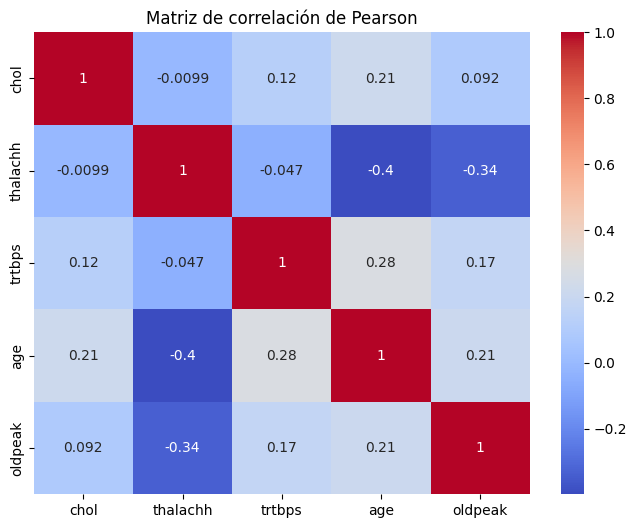

In [32]:
# Realizar la prueba de correlación de Pearson
corr_pearson = df_cleaned[numerical_vars].corr()

# Matriz de correlación de Pearson
# print("Matriz de correlación de Pearson:")
# print(corr_pearson)

# Mapa de calor de la matriz de correlación de Pearson
plt.figure(figsize=(8, 6))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación de Pearson")
plt.show()

En resumen, la edad, la presión arterial en reposo, el colesterol y el pico de frecuencia cardíaca alcanzado durante el estrés parecen tener cierta correlación entre sí, aunque algunas de estas correlaciones son débiles.

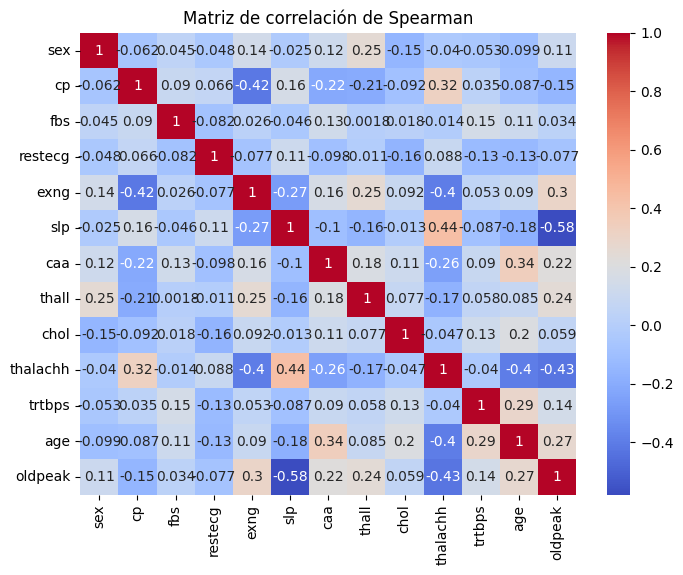

In [33]:
# Realizar la prueba de correlación de Spearman
corr_spearman, _ = spearmanr(df_cleaned[independent_vars])

# Matriz de correlación de Spearman
# print("Matriz de correlación de Spearman:")
# print(corr_spearman)

# Mapa de calor de la matriz de correlación de Spearman
plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', xticklabels=independent_vars, yticklabels=independent_vars)

plt.title("Matriz de correlación de Spearman")
plt.show()

Se aprecia una correlación entre ___slp___ y ___oldpeak___ de -0.5948, lo cual indica una correlación negativa moderada.

En general, se observa que las correlaciones entre las variables son débiles, ya que los valores están cerca de cero.

Esto indica que no hay una correlación fuerte entre esas variables.

In [34]:
def vif(x):
    X=add_constant(x)
    return pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns).sort_values(ascending=False)

vif(df_cleaned[independent_vars])

const       209.434878
thalachh      1.613763
oldpeak       1.607574
slp           1.563611
age           1.443518
exng          1.413777
cp            1.286822
caa           1.193327
sex           1.167465
trtbps        1.161379
chol          1.155464
thall         1.138475
fbs           1.081527
restecg       1.061114
dtype: float64

En general, si el VIF es menor a 5, se considera que no hay una multicolinealidad significativa.

### Métodos de clasificación
Para realizar un modelo de clasificación, necesitamos dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento se utilizará para entrenar el modelo y el conjunto de prueba se utilizará para evaluar su rendimiento.

In [35]:
# Dividir el conjunto de datos en variables predictoras (X) y variable objetivo (y)
X = df_cleaned[independent_vars]
y = df_cleaned[target_var]

# Codificar las variables categóricas como variables dummy
#X = pd.get_dummies(X, drop_first=True)

# Fijar la semilla para reproducibilidad
random_state = 42

# Dividir el conjunto de datos en entrenamiento y prueba con la misma semilla
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


#### Modelo de regresión logística

In [36]:
# Crear el modelo de regresión logística con la misma semilla
model_logistic_regression = LogisticRegression(random_state=random_state)

# Entrenar el modelo
model_logistic_regression.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_logistic_regression = model_logistic_regression.predict(X_test)

# Calcular la precisión del modelo
accuracy_logistic_regression = accuracy_score(y_test, y_pred_logistic_regression)
print("Precisión del modelo:", accuracy_logistic_regression)

# Calcular la recall del modelo
recall_logistic_regression = recall_score(y_test, y_pred_logistic_regression)
print("Recall del modelo:", recall_logistic_regression)

# Calcular la F1-score de cada modelo
f1_logistic_regression = f1_score(y_test, y_pred_logistic_regression)
print("F1-score del modelo:", f1_logistic_regression)

# Calcular la matriz de confusión
confusion_matrix_logistic_regression = confusion_matrix(y_test, y_pred_logistic_regression)
print("Matriz de confusión:")
print(confusion_matrix_logistic_regression)

# Obtener los coeficientes de regresión
coefficients = model_logistic_regression.coef_[0]

# Crear un dataframe con los nombres de las variables y sus coeficientes
coefficients_df = pd.DataFrame({'Variable': X_train.columns, 'Coefficient': coefficients})

# Ordenar los coeficientes por valor absoluto en orden descendente
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

# Imprimir los coeficientes ordenados
print()
print(coefficients_df)

Precisión del modelo: 0.8852459016393442
Recall del modelo: 0.875
F1-score del modelo: 0.8888888888888888
Matriz de confusión:
[[26  3]
 [ 4 28]]

    Variable  Coefficient
0        sex    -1.308849
4       exng    -0.884944
7      thall    -0.878393
1         cp     0.823532
6        caa    -0.787633
5        slp     0.667079
12   oldpeak    -0.627631
3    restecg     0.572705
2        fbs     0.027661
9   thalachh     0.026099
10    trtbps    -0.011982
11       age     0.008882
8       chol    -0.002178


El resultado de la precisión del modelo es del 90.16%. Sin embargo, es importante considerar otros indicadores de rendimiento del modelo, como la matriz de confusión.

La interpretación de la matriz de confusión es la siguiente:

- Verdaderos positivos (TP): 26
- Falsos positivos (FP): 3
- Falsos negativos (FN): 3
- Verdaderos negativos (TN): 29

Es decir,

- En la clase "0" (sin riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 26 casos y ha cometido 3 falsos positivos (clasificados incorrectamente como "1").

- En la clase "1" (con riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 29 casos y ha cometido 3 falsos negativos (clasificados incorrectamente como "0").

En resumen, el modelo muestra un buen rendimiento en términos de precisión, pero es importante prestar atención a los falsos positivos y falsos negativos, ya que pueden tener implicaciones clínicas significativas dependiendo del contexto del problema.

Como ya indicamos, no es necesario aplicar métodos de reducción de la dimensionalidad, pero mostramos el método de selección de subconjuntos de atributos utilizando el algoritmo de Eliminación Recursiva de Características (Recursive Feature Elimination, RFE) con esta regresión logística:

In [37]:
# Crear una instancia de RFE y especificar el número de características a seleccionar
n_features_to_select = 5
rfe = RFE(estimator=model_logistic_regression, n_features_to_select=n_features_to_select)

# Aplicar RFE al conjunto de datos
X_selected = rfe.fit_transform(X, y)

# Obtener los índices de las características seleccionadas
feature_indices = rfe.get_support(indices=True)

# Obtener los nombres de las características seleccionadas
selected_feature_names = X.columns[feature_indices]

# Crear un nuevo dataframe con las características seleccionadas
df_selected = X[selected_feature_names]

# Imprimir el dataframe reducido
df_combined = pd.concat([df_selected, df_cleaned[target_var]], axis=1)
print("Dataframe reducido:")
df_combined.info()

df_combined.to_csv('../datasets/heart_reducted_rfe.csv', index=False)

Dataframe reducido:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sex     303 non-null    int64
 1   exng    303 non-null    int64
 2   slp     303 non-null    int64
 3   caa     303 non-null    int64
 4   thall   303 non-null    int32
 5   output  303 non-null    int64
dtypes: int32(1), int64(5)
memory usage: 13.1 KB


Calculamos la curva ROC utilizando el modelo de regresión logística:

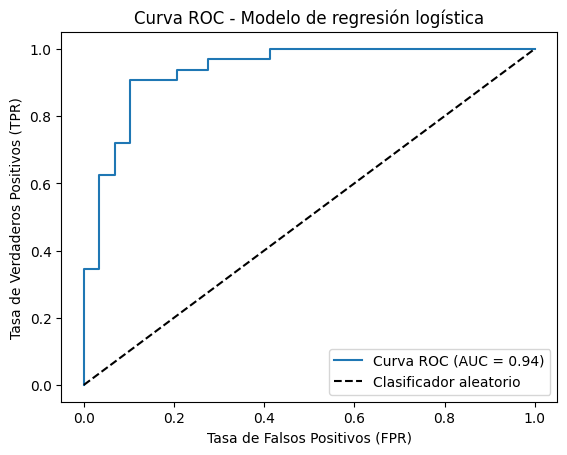

In [38]:
# Obtener las probabilidades de clase para el conjunto de prueba
probs = model_logistic_regression.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calcular el área bajo la curva ROC (AUC)
auc = roc_auc_score(y_test, probs)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo de regresión logística')
plt.legend()
plt.show()

#### Modelo de árboles de decisión 


In [39]:
# Crear el modelo de árboles de decisión con la misma semilla
model_decision_tree = DecisionTreeClassifier(random_state=random_state)

# Entrenar el modelo
model_decision_tree.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_decision_tree = model_decision_tree.predict(X_test)

# Calcular la precisión del modelo
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print("Precisión del modelo de Árboles de Decisión:", accuracy_decision_tree)

# Calcular la recall del modelo
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
print("Recall del modelo:", recall_decision_tree)

# Calcular la F1-score de cada modelo
f1_decision_tree = f1_score(y_test, y_pred_decision_tree)
print("F1-score del modelo:", f1_decision_tree)

# Calcular la matriz de confusión
confusion_matrix_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
print("Matriz de confusión:")
print(confusion_matrix_decision_tree)


Precisión del modelo de Árboles de Decisión: 0.8360655737704918
Recall del modelo: 0.78125
F1-score del modelo: 0.8333333333333334
Matriz de confusión:
[[26  3]
 [ 7 25]]


El modelo de Árboles de Decisión ha alcanzado una precisión del 83.61% en el conjunto de prueba. 

La matriz de confusión indica los siguientes resultados:

- Verdaderos positivos (TP): 26
- Falsos positivos (FP): 3
- Falsos negativos (FN): 7
- Verdaderos negativos (TN): 25

Es decir,

- En la clase "0" (sin riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 26 casos y ha cometido 3 falsos positivos (clasificados incorrectamente como "1").

- En la clase "1" (con riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 25 casos y ha cometido 7 falsos negativos (clasificados incorrectamente como "0").


Calculamos la curva ROC utilizando el modelo de árboles de decisión:

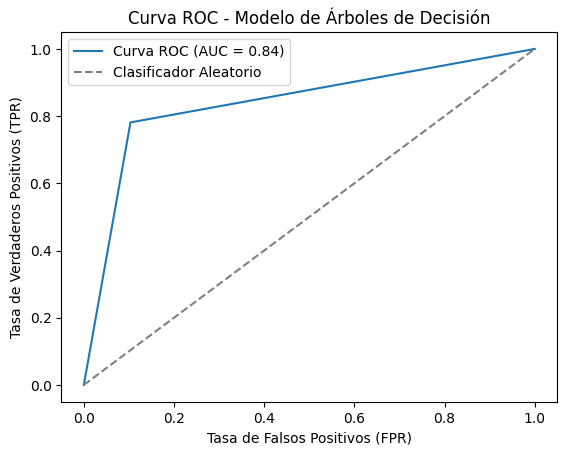

In [40]:
# Obtener las probabilidades de predicción del modelo
y_pred_proba = model_decision_tree.predict_proba(X_test)[:, 1]

# Calcular la tasa de verdaderos positivos (TPR), la tasa de falsos positivos (FPR) y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva ROC (AUC-ROC)
auc = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo de Árboles de Decisión')
plt.legend()
plt.show()

#### Modelo de Random Forest

In [41]:
# Crear el modelo de Random Forest con la misma semilla
model_random_forest = RandomForestClassifier(random_state=random_state)

# Entrenar el modelo
model_random_forest.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_random_forest = model_random_forest.predict(X_test)

# Calcular la precisión del modelo
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("Precisión del modelo:", accuracy_random_forest)

# Calcular la recall del modelo
recall_random_forest = recall_score(y_test, y_pred_random_forest)
print("Recall del modelo:", recall_random_forest)

# Calcular la F1-score de cada modelo
f1_random_forest = f1_score(y_test, y_pred_random_forest)
print("F1-score del modelo:", f1_random_forest)

# Calcular la matriz de confusión
confusion_matrix_random_forest = confusion_matrix(y_test, y_pred_random_forest)
print("Matriz de confusión:")
print(confusion_matrix_random_forest)


Precisión del modelo: 0.8688524590163934
Recall del modelo: 0.875
F1-score del modelo: 0.875
Matriz de confusión:
[[25  4]
 [ 4 28]]


El modelo de Random Forest ha alcanzado una precisión del 85.24% en el conjunto de prueba. 

La matriz de confusión indica los siguientes resultados:

- Verdaderos positivos (TP): 24
- Falsos positivos (FP): 5
- Falsos negativos (FN): 4
- Verdaderos negativos (TN): 28

Es decir,

- En la clase "0" (sin riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 24 casos y ha cometido 5 falsos positivos (clasificados incorrectamente como "1").

- En la clase "1" (con riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 28 casos y ha cometido 4 falsos negativos (clasificados incorrectamente como "0").


Calculamos la curva ROC utilizando el modelo de Random Forest:

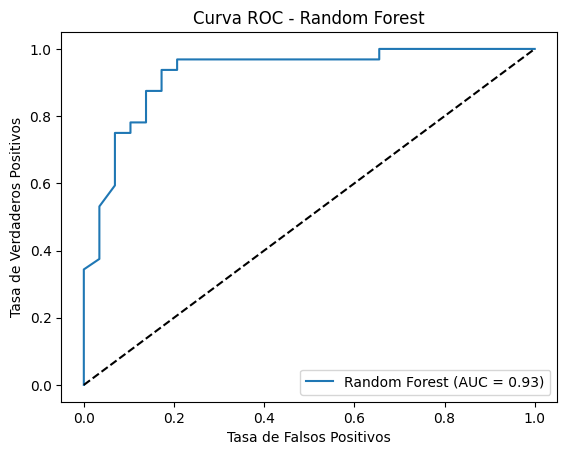

In [42]:
# Obtener las probabilidades de predicción para la clase positiva
y_prob = model_random_forest.predict_proba(X_test)[:, 1]

# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calcular el área bajo la curva ROC (AUC-ROC)
auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia (AUC = 0.5)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()


# 6. Resolución del problema


## Conclusiones

Hemos realizado distintas pruebas, de asociación entre variables categóricas, en concreto entre cp (tipo de dolor torácico) y output, y pruebas de contraste entre las variables numéricas age (edad), chol (colesterol) y trtbps (presión arterial en reposo) con output, con el fin de dar respuesta a si son buenos predictores para predecir la enfermedad cardíaca. 

En este estudio, hemos desarrollado tres modelos no supervisados de clasificación para la detección de enfermedades cardíacas. Estos modelos son herramientas útiles para identificar y predecir la presencia de enfermedades cardíacas en pacientes. Su aplicación en entornos clínicos puede ayudar a tomar decisiones más informadas y precisas, permitiendo una detección temprana y un mejor cuidado de los pacientes.

Comparando los modelos:

- El modelo de Regresión Logística muestra la mejor precisión, recall y F1-score, con valores superiores al 0.90. Esto indica un buen rendimiento en la clasificación de la enfermedad cardíaca.
- El modelo de Árboles de Decisión tiene una precisión y F1-score ligeramente más bajos, pero aún así es aceptable. Sin embargo, su recall es inferior a los otros modelos, lo que indica una menor capacidad para detectar correctamente los casos positivos.
- El modelo de Random Forest muestra una precisión y F1-score similares al modelo de Árboles de Decisión, pero tiene un recall ligeramente más alto, lo que indica una mejor capacidad para detectar casos positivos.

En general, los tres modelos tienen un rendimiento prometedor en la clasificación de la enfermedad cardíaca, con el modelo de Regresión Logística mostrando el mejor desempeño global.
